#**Modified parallel tangents method** (модифицированный партан-метод). 
Существует и итерационная версия этого алгоритма, модифицированная отличается тем, что требует запоминания дополнительных параметров на каждом шаге. \\
**Итерационная версия** строится так: в начальной точке $w_0$ вычисляется градиент оценки $E$ и делается шаг наискорейшего спуска - для этого используется одномерная оптимизация. Далее снова вычисляется градиент и выполняется спуск (т.е. перемещение в направлении антиградиента) и т.д. Описанный процесс повторяется $k$ раз. После $k$ шагов наискорейшего спуска получаем точку $w_k$ и проводом одномерную оптимизацию из исходной точки $w_0$ в направлении $d = w_k - w_0$ с начальным шагом $\alpha = 1$. После этого цикл повторяется. \\
**Модифицированная версия** строится следующим образом: \\
1) из начальной точки $w_0$ делается 2 шага наискорейшего спуска - получаем точки $w_1, w_2$ \\
2) выполняем одномерную оптимизацию из точки $w_0$ в направлении $w_2 - w_0$ - получаем точку $w_3$ \\
3) выполняем наискорейший спуск из $w_3$ - получаем точку $w_4$ \\
4) выполняем одномерную оптимизацию из точки $w_2$ в направлении $w_4 - w_2$ - получаем $w_5$ и т.д. \\
Таким образом, $w_{2k}$ получаем наискорейшим спуском из $w_{2k-1}$, $w_{2k+1}$ - одномерной оптимизацией из $w_{2k-2}$ в направлении $d = w_{2k} - w_{2k-2}$ с начальным шагом 1.


![picture](https://drive.google.com/uc?export=view&id=16xLWt9aL9rwzllkCcrKCKlhJ79kAdwgq)

На картинке: из точки $x_0$ строим точки $x_1$ и $y_1$ методом наискорейшего спуска. Затем выполняется одномерная оптимизация из точки $x_0$ в направлении $y_1 - x_0$ - получаем $x_2$. Снова делаем шаг наискорейшего спуска, но уже из точки $x_2$, чтобы получить точку $y_2$, затем выполняем одномерную оптимизацию и т.д. \\
Доказательство корректности алгоритма в целом схоже с обоснованием корректности метода наискорейшего спуска - было замечено, что последовательные точки в его итерациях попадают на две линии, которые пересекаются в окрестности минимума (см. рисунок ниже). Поэтому по сути ПарТан состоит в выполнении двух шагов наискорейшего спуска и дальнейшем поиске следующей точки на прямой, которая соединяет начальную точку с точкой из второй итерации.

![picture](https://drive.google.com/uc?export=view&id=1bc5MqhtKxNnphcSNuv0fGX_CRCiHMdqc)

(изображения взяты из этой книги - <a href="https://link.springer.com/content/pdf/10.1007%2F978-0-387-71107-2_6.pdf">ссылка</a>, подробное обоснование корректности тоже можно найти в ней - страницы 168-171).

Реализуем ПарТан и наискорейший градиентный спуск и сравним их эффективность на функции двух переменных - функции Химмельблау: $f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$. \\
Для вычисления оптимального шага на итерации алгоритма будем использовать комбинацию алгоритмов Свенна и золотого сечения (сначала Свенном ищем первичный интервал, затем на нём методом золотого сечения следующую точку). 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [32]:
# Вспомогательные функции
tol = 1e-3


def function(point):
  x, y = point
  return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

def gradient(point):
  x, y = point
  return np.array([4 * x * (x ** 2 + y - 11) + 2 * (x + y ** 2 - 7),
                    2 * (x ** 2 + y - 11) + 4 * y * (x + y ** 2 - 7)])

def step(x, grad, alpha):
    return x - grad * alpha

def norm(s1):
    return np.sqrt(np.sum(s1 ** 2))

def find_alpha(x0, grad, alpha):
    initial_cut = svenn_method(x0, grad, alpha, 0.1)
    cut = golden_ratio_method(initial_cut[0], initial_cut[1], x0, grad)
    return np.mean(cut)         

# Свенн
def svenn_method(x0, grad, alpha, t):
    f0 = function(step(x0, grad, alpha))
    f1 = function(step(x0, grad, alpha - t))
    f2 = function(step(x0, grad, alpha + t))
    if f0 < f2:
        t = -t
    x1 = alpha + t
    while f1 < f0:
        t *= 2
        alpha = x1
        x1 = alpha + t
        f0 = f1
        f1 = function(step(x0, grad, x1))
    a = alpha + t/2
    b = alpha - t/2        
    if f0 < f1:
      return np.sort(np.array([a, b]))
    elif f1 < f0:
      return np.sort(np.array([x1, alpha]))
    else:
      return np.sort(np.array([b, alpha]))

# Метод золотого сечения
def golden_ratio_method(a, b, x0, grad):
    len = b - a
    x1 = a + 0.382 * len
    x2 = a + 0.618 * len
    while len > tol:
        if function(step(x0, grad, x1)) < function(step(x0, grad, x2)):
            b = x2
            x2 = x1
            len = b - a
            x1 = a + 0.382 * len
        else:
            a = x1
            x1 = x2
            len = b - a
            x2 = a + 0.618 * len   
    return np.array([a, b])

# Собственно, ПарТан
def partan(x0, plot_needed=True):
    grad = gradient(x0)
    alpha = 0.01
    points = []
    points.append(x0)
    while (norm(grad) >= tol):
        # нашли первую точку
        alpha = find_alpha(x0, grad, alpha)
        x1 = step(x0, grad, alpha)
        grad = gradient(x1)
        # нашли вторую точку
        alpha = find_alpha(x1, grad, alpha)
        x2 = step(x1, grad, alpha)
        # делаем шаг в найденном направлении
        grad = x2 - x0
        alpha = find_alpha(x2, grad, alpha)
        x0 = step(x2, grad, alpha)
        grad = gradient(x0)
        points.append(x0)
    points = np.array(points)    
    if plot_needed:
      plot(points, 'ParTan steps')    
    return points

def fastestDescent(x0, plot_needed=True):
    points = []
    points.append(x0)
    x0 = x0 * (-1)
    x1 = -x0
    alpha = 0.1
    while norm(x1 - x0)/norm(x0) >= tol:
        x0 = x1
        grad = gradient(x0)
        if norm(grad) < tol:
            break
        alpha = find_alpha(x0, grad, alpha)
        x1 = step(x0, grad, alpha)
        points.append(x1)
    points = np.array(points)
    if plot_needed:
      plot(points, 'FD steps')
    return points   

def plot(points, label, optional=None, optional_label=None):
    n = 1000
    x = np.linspace(-6, 6, n)
    y = np.linspace(-6, 6, n)
    X, Y = np.meshgrid(x, y)
    plt.figure(figsize=(8, 8))
    z = function([X, Y])
    colors = sns.color_palette("Blues")
    plt.contourf(X, Y, z, levels=60, colors=colors)
    plt.plot(points.T[0], points.T[1], marker='o', linestyle='--', color='black', label=label)
    if optional is not None:
      plt.plot(optional.T[0], optional.T[1], marker='o', color='red', linestyle='--', label=optional_label)   
    plt.legend()
    plt.show()        

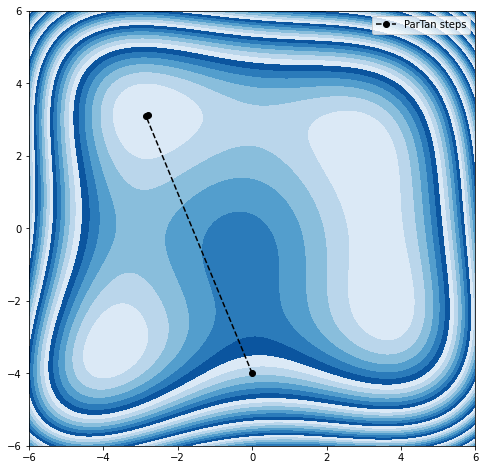

Полученный результат:  [-2.8051114   3.13131626]
Понадобилось шагов:  3


In [20]:
point = np.array([0, -4])
result_partan = partan(point)
print("Полученный результат: ", result_partan[-1])
print("Понадобилось шагов: ", len(result_partan))

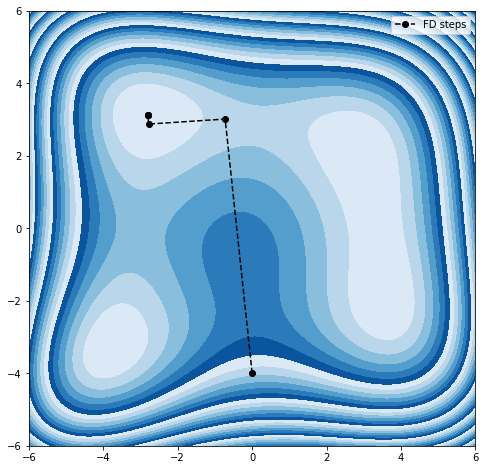

Полученный результат:  [-2.80507986  3.13132974]
Понадобилось шагов:  6


In [21]:
result_fd = fastestDescent(point)
print("Полученный результат: ", result_fd[-1])
print("Понадобилось шагов: ", len(result_fd))

Видим, что ПарТану потребовалось намного меньше итераций, чем наибыстрейшему спуску. Построим на одном графике шаги обоих алгоритмов: 

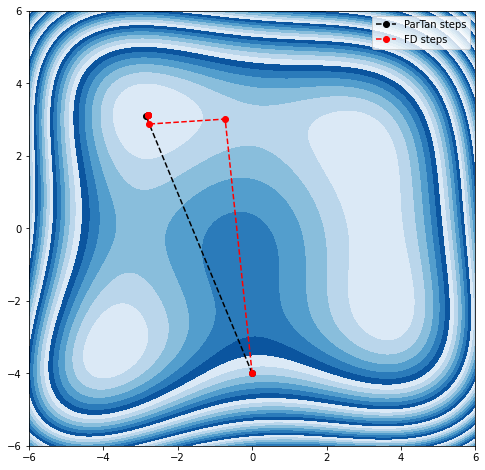

In [22]:
plot(result_partan, 'ParTan steps', result_fd, 'FD steps')

Замечаем так же, что метод параллельных тангенсов действительно "пропускает" некоторые шаги второго метода - сразу делает шаг в направлении второй найденной в ходе спуска точки. Продемонстрируем на еще одной точке:

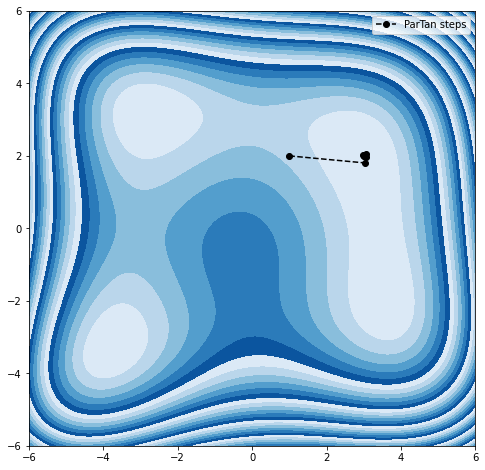

Полученный результат:  [3.0000116  2.00000324]
Понадобилось шагов:  7


In [25]:
point = np.array([1,  2])
result_partan = partan(point)
print("Полученный результат: ", result_partan[-1])
print("Понадобилось шагов: ", len(result_partan))

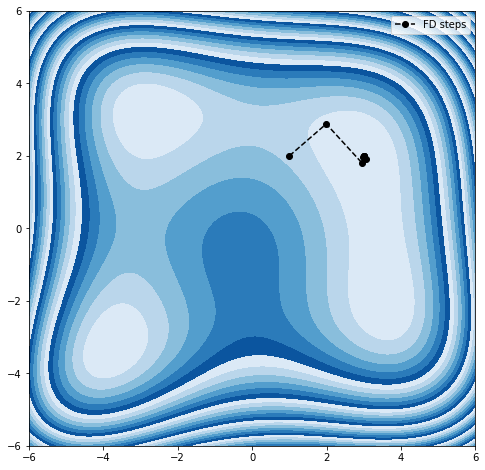

Полученный результат:  [2.99977913 1.99938754]
Понадобилось шагов:  9


In [26]:
result_fd = fastestDescent(point)
print("Полученный результат: ", result_fd[-1])
print("Понадобилось шагов: ", len(result_fd))

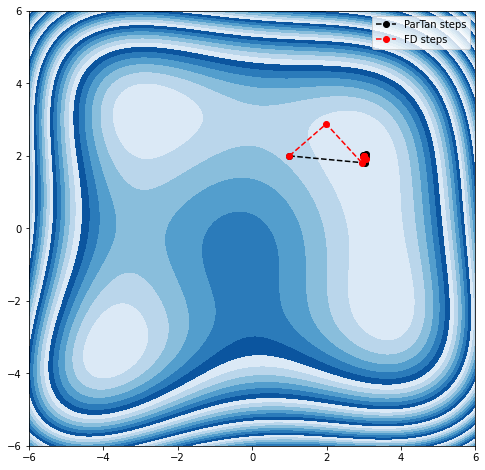

In [27]:
plot(result_partan, 'ParTan steps', result_fd, 'FD steps')

#**Вывод** 
ПарТан действительно требует меньшего числа итераций, чем наискорейший градиентный спуск, однако в целом проделывает такие же шаги - рассчитывает те же данные, которые использует для шага градиентный спуск, только отбрасывает часть из них, не используя. Но метод действительно работает - находит локальный минимум достаточно точно за малое число шагов.